In [2]:
import os
import uuid
import shutil
#import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
#from pylatex.section import Chapter, Subsection
#from pylatex import Document, Section, Figure, NoEscape, Command

%run pipeline.ipynb

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [3]:
lclist=pd.read_csv('lcscoresandchecker.csv')

In [4]:
#staufferids=np.concatenate((np.arange(0,21),np.array([116]),np.arange(129,141)))

In [5]:
#staufferids.size

In [6]:
#lclist[lclist.pop_id.isin(staufferids)][['pop_id','idtype','secorcamp']]

In [7]:
incamp2=np.unique(lclist[np.logical_and(np.logical_and(np.logical_and(lclist.paper_author=='Stauffer',
                                                    np.logical_or(lclist.year==2017,lclist.year==2018)),
                                     lclist.secorcamp==2),
                      lclist.idtype=='EPIC')].pop_id)

In [8]:
insec91=np.unique(lclist[np.logical_and(np.logical_and(np.logical_and(lclist.paper_author=='Stauffer',
                                                    np.logical_or(lclist.year==2017,lclist.year==2018)),
                                     lclist.secorcamp==91),
                      lclist.idtype=='TIC')].pop_id)

In [9]:
ids,counts=np.unique(lclist[np.logical_and(lclist.paper_author=='Stauffer',
                                np.logical_or(lclist.year==2017,lclist.year==2018))].pop_id,return_counts=True)
cols={'ids':ids,'counts':counts}
allstauffer=pd.DataFrame(cols)
just3=allstauffer[allstauffer.counts==3].ids

In [10]:
plotids=pd.DataFrame(np.intersect1d(np.intersect1d(incamp2, insec91), just3),columns=['pop_id'])

In [11]:
plotids['include']=True
plotids['period']=1
plotids['k2lc']='K2SFF'

In [12]:
plotids.at[3,'k2lc']='EVEREST'
plotids.at[22,'k2lc']='EVEREST'
plotids.at[22,'include']=False
plotids.at[23,'k2lc']='EVEREST'
plotids.at[17,'include']=False

In [13]:
plotids

pop_id  include  period     k2lc
0        3     True       1    K2SFF
1        4     True       1    K2SFF
2        5     True       1    K2SFF
3        6     True       1  EVEREST
4        7     True       1    K2SFF
5        8     True       1    K2SFF
6        9     True       1    K2SFF
7       10     True       1    K2SFF
8       11     True       1    K2SFF
9       12     True       1    K2SFF
10      13     True       1    K2SFF
11      14     True       1    K2SFF
12      16     True       1    K2SFF
13      17     True       1    K2SFF
14      18     True       1    K2SFF
15      20     True       1    K2SFF
16     130     True       1    K2SFF
17     131    False       1    K2SFF
18     132     True       1    K2SFF
19     134     True       1    K2SFF
20     135     True       1    K2SFF
21     136     True       1    K2SFF
22     137    False       1  EVEREST
23     138     True       1  EVEREST
24     139     True       1    K2SFF
25     140     True       1    K2SFF

In [14]:
lclist.head(5)

pop_id                          lcname idtype         ID  secorcamp  \
0       0  EPIC-246676629-13-EVEREST-1800   EPIC  246676629         13   
1       0    EPIC-246676629-13-K2SFF-1800   EPIC  246676629         13   
2       0        TIC-59129133-5-FFI-30min    TIC   59129133          5   
3       0       TIC-59129133-32-FFI-10min    TIC   59129133         32   
4       0        TIC-59129133-43-SPOC-120    TIC   59129133         43   

  LC_author cadence  fluxamplitude       TIC  gaiadr3_source_id      epic_id  \
0   EVEREST    1800       0.075449  59129133       3.392549e+18  246676629.0   
1     K2SFF    1800       0.083411  59129133       3.392549e+18  246676629.0   
2       FFI   30min       0.041935  59129133       3.392549e+18  246676629.0   
3       FFI   10min       0.053793  59129133       3.392549e+18  246676629.0   
4      SPOC     120       0.053993  59129133       3.392549e+18  246676629.0   

      per    per2   group  age_Myr    disco_paper paper_author  year  Score1  \
0  0.6253  0.6332  Taurus      2.0  Stauffer_2018     Stauffer  2018     2.0   
1  0.6253  0.6332  Taurus      2.0  Stauffer_2018     Stauffer  2018     2.0   
2  0.6253  0.6332  Taurus      2.0  Stauffer_2018     Stauffer  2018     2.0   
3  0.6253  0.6332  Taurus      2.0  Stauffer_2018     Stauffer  2018     2.0   
4  0.6253  0.6332  Taurus      2.0  Stauffer_2018     Stauffer  2018     2.0   

   Flare1  Shelf1  Evolution1                                      Notes1  \
0     0.0     0.0         1.0                                         NaN   
1     0.0     0.0         0.0  EVEREST is actually better for this object   
2     1.0     0.0         1.0                                         NaN   
3     0.0     0.0         1.0                                         NaN   
4     2.0     1.0         1.0                                         NaN   

   Score2  Flare2  Shelf2  Evolution2  \
0     1.0     0.0     0.0         0.0   
1     1.0     0.0     0.0         0.0   
2     1.0     1.0     0.0         1.0   
3     2.0     0.0     0.0         0.0   
4     2.0     2.0     0.0         1.0   

                                     Notes2 complex_status1 complex_status2  
0        Very hard to tell what's going on          Complex         Complex  
1  Cadence has lined up weirdly with period         Complex         Complex  
2                                       NaN         Complex         Complex  
3                                       NaN         Complex         Complex  
4   Literature period might be a little off         Complex         Complex

In [15]:
k2name=lclist[np.logical_and(np.logical_and(lclist.pop_id==3,lclist.secorcamp==2),lclist.LC_author=='K2SFF')].lcname.values[0]

In [16]:
def double_lc(pop_id,k2lc,period):
    k2row=lclist[np.logical_and(np.logical_and(lclist.pop_id==pop_id,lclist.secorcamp==2),lclist.LC_author==k2lc)]
    k2name=k2row.lcname.values[0]
    lc2=get_lc_string(k2name).normalize()
    tessrow=lclist[np.logical_and(lclist.pop_id==pop_id,lclist.secorcamp==91)]
    tessname=tessrow.lcname.values[0]
    lc91=get_lc_string(tessname)
    if tessrow.LC_author.values[0]=='FFI':
        lc91.flux=lc91.flux+1
    else:
        lc91=lc91.normalize()
    if period==1:
        period=u.Quantity(k2row.per.values[0],u.d)
    else:
        period=u.Quantity(k2row.per2.values[0],u.d)
    bintime=u.Quantity(period/200,u.s)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    subgraph_phaselc(lc2,period=period,ax=ax1,bintime=bintime,showperiod=False)
    subgraph_phaselc(lc91,period=period,ax=ax2,bintime=bintime,showperiod=False)
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax1.tick_params(direction='in')
    ax2.tick_params(direction='in')
    plt.subplots_adjust(wspace=0)
    # ax1.set_title('Campaign 2')
    # ax2.set_title('Sector 91')
    #fig.suptitle(f'{pop_id}, TIC {k2row.TIC.values[0]}, {period}',y=0.94)
    fig.suptitle(f'TIC {k2row.TIC.values[0]}, {period}',y=0.94)
    #fig.savefig(f'multiplots/comparison/{pop_id}.png',bbox_inches='tight')
    return fig

In [17]:
fig_images = []

In [18]:
for index, row in plotids.iterrows():
    if row['include']==True:
        fig = double_lc(row.pop_id, row.k2lc, row.period)  # your original function
        fig.tight_layout()
        fig.set_dpi(300)
        fig.canvas.draw()
        img = np.array(fig.canvas.renderer.buffer_rgba())
        fig_images.append(img)
        plt.close(fig)

In [19]:
plt.close('all')

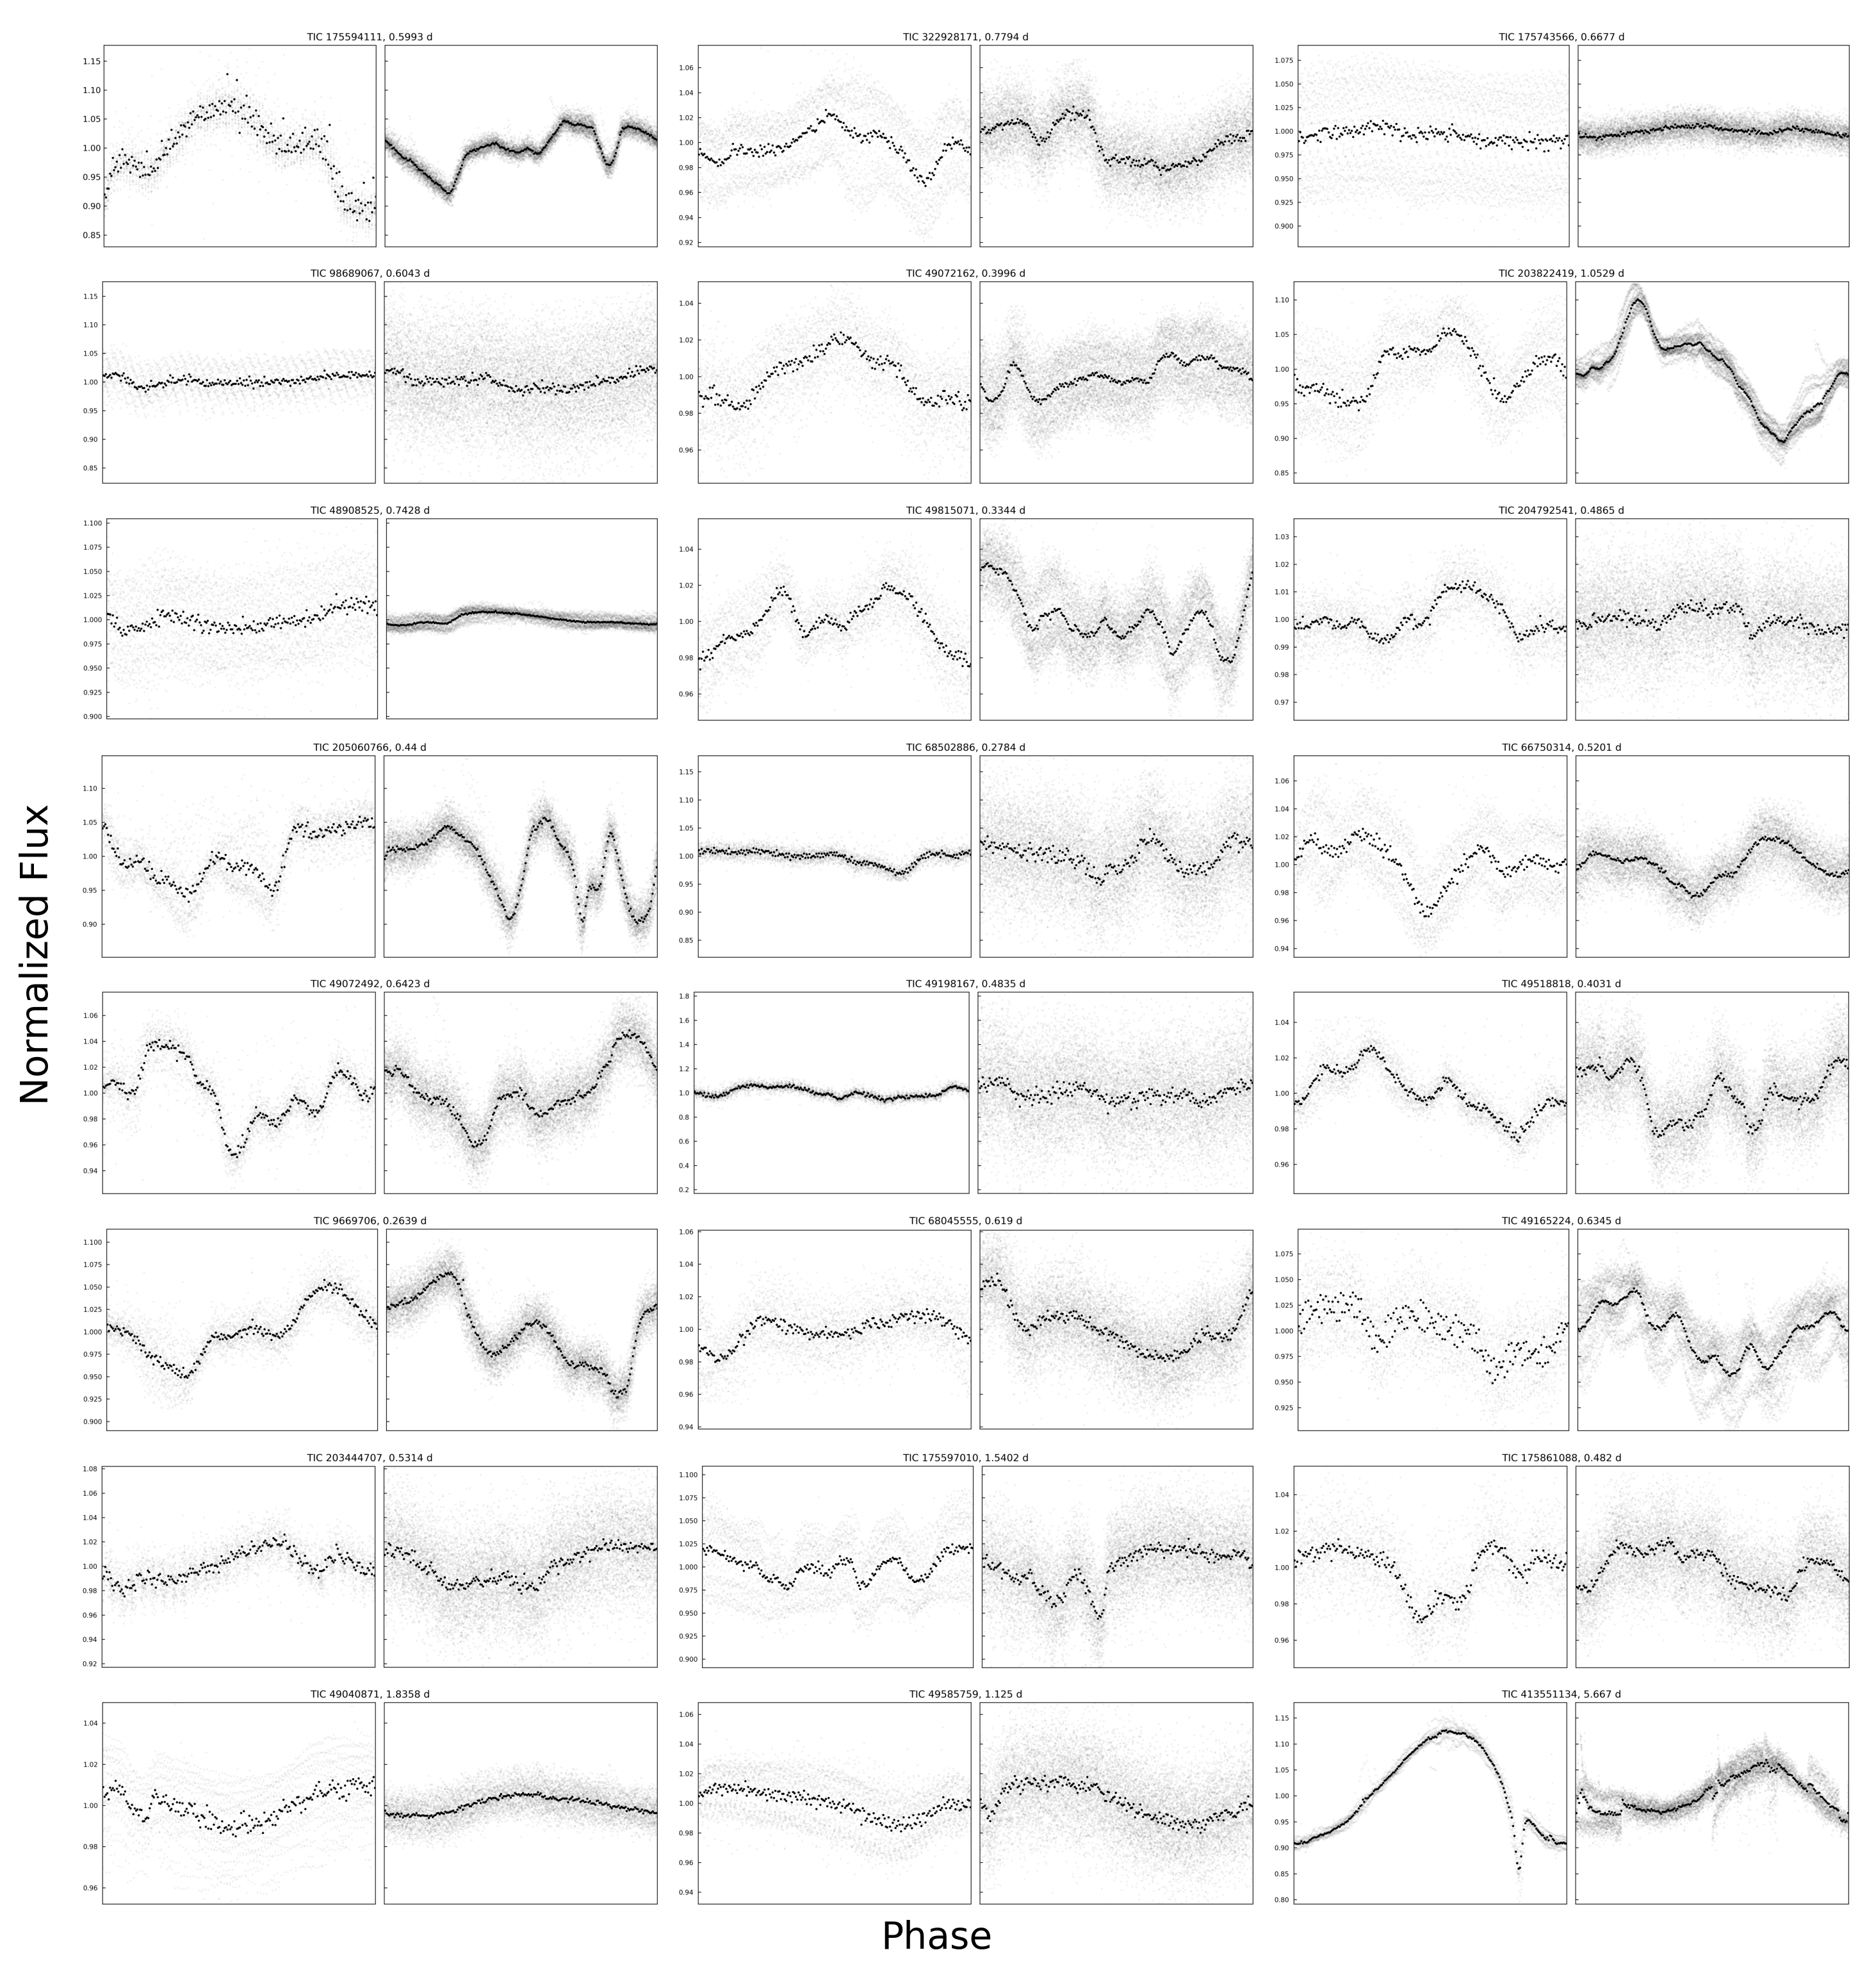

In [55]:
# Step 2: Decide grid size
ncols = 3
nrows = int(np.ceil(np.sum(plotids.include)/ncols))

# Compute aspect ratio of images
img_h, img_w, _ = fig_images[0].shape
aspect = img_h / img_w 

# Create master figure
fig = plt.figure(figsize=(ncols*4, nrows*4*aspect),dpi=300)
gs = gridspec.GridSpec(nrows, ncols, wspace=0.0, hspace=0.0)

for i, img in enumerate(fig_images):
    row = i // ncols
    col = i % ncols
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img)
    ax.axis('off')

fig.text(0.5, 0.1, "Phase", ha='center', va='center', fontsize=14)
fig.text(0.11, 0.5, "Normalized Flux", ha='center', va='center', rotation='vertical', fontsize=14)

plt.show()
fig.savefig('multiplots/comparison/megaplot.png',bbox_inches='tight')